# 📈 Order Book Performance Analysis

This notebook analyzes the performance of the Rust `OrderBook` implementation. We will load the CSV data generated by the `criterion` benchmarks and create a series of visualizations to understand:

1.  **Scalability**: How does performance change as the number of orders in the book increases?
2.  **Operation Cost**: What is the relative cost of different operations like market orders, limit orders, and cancellations?
3.  **Parameter Impact**: How do factors like sweep volume and price level density affect performance?
4.  **Scenario Analysis**: How does the book perform under specific trading scenarios like short covering?

---

## 1. Setup and Data Loading

First, we import the necessary libraries and load all the benchmark result files (`.csv`) from the `benchmark_results/` directory into a single pandas DataFrame.

In [1]:
!pip install seaborn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

# Set plot style and color palette for aesthetics
sns.set_theme(style="whitegrid", palette="viridis")
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


In [2]:
def load_benchmark_data(path):
    """Loads and concatenates all benchmark CSVs from a directory."""
    csv_files = glob.glob(os.path.join(path, '*.csv'))
    if not csv_files:
        print(f"Warning: No CSV files found in '{path}'. Please run the benchmarks first.")
        # Create a dummy comprehensive file to avoid errors, assuming it's the main one needed
        # In a real scenario, you'd run the bench code first.
        dummy_path = os.path.join(path, 'comprehensive_benchmark_results.csv')
        if not os.path.exists(dummy_path):
            if not os.path.exists(path):
                 os.makedirs(path)
            with open(dummy_path, 'w') as f:
                f.write('benchmark_group,test_name,parameter,book_size,sweep_volume,price_levels,side,mean_time_ns,std_dev_ns,throughput_elements_per_sec,sample_count\n')
            print(f"Created a dummy file at '{dummy_path}'.")
            csv_files = [dummy_path]
            
    # We are interested in the comprehensive results for overall analysis
    comprehensive_file = os.path.join(path, 'comprehensive_benchmark_results.csv')
    if os.path.exists(comprehensive_file):
        df = pd.read_csv(comprehensive_file)
        print(f"Successfully loaded {len(df)} records from '{comprehensive_file}'")
        return df
    else:
        print(f"Error: Comprehensive results file not found at '{comprehensive_file}'")
        return pd.DataFrame()

# Load the data
data_path = 'benchmark_results/'
df = load_benchmark_data(data_path)

# Data preprocessing
if not df.empty:
    # Convert time from nanoseconds to milliseconds for easier interpretation
    df['mean_time_ms'] = df['mean_time_ns'] / 1_000_000
    df['std_dev_ms'] = df['std_dev_ns'] / 1_000_000

    # Display the first few rows and a summary of the data
    display(df.head())
    display(df.info())
else:
    print("DataFrame is empty. Cannot proceed with analysis.")

Successfully loaded 65 records from 'benchmark_results/comprehensive_benchmark_results.csv'


,benchmark_group,test_name,parameter,book_size,sweep_volume,price_levels,side,mean_time_ns,std_dev_ns,throughput_elements_per_sec,sample_count,mean_time_ms,std_dev_ms
0,market_order_scaling,sell_book_market_order,sell_book_10000_sweep_1000,10000,1000.0,NaN,Buy,530.81,117.48,1.883913e+10,100,0.000531,0.000117
1,market_order_scaling,sell_book_market_order,sell_book_10000_sweep_25000,10000,25000.0,NaN,Buy,7607.50,636.14,1.314492e+09,100,0.007607,0.000636
2,market_order_scaling,sell_book_market_order,sell_book_10000_sweep_100000,10000,100000.0,NaN,Buy,27176.24,4050.02,3.679685e+08,100,0.027176,0.004050
3,market_order_scaling,sell_book_market_order,sell_book_10000_sweep_250000,10000,250000.0,NaN,Buy,63749.62,8933.80,1.568637e+08,100,0.063750,0.008934
4,market_order_scaling,sell_book_market_order,sell_book_10000_sweep_1000000,10000,1000000.0,NaN,Buy,250139.61,9716.66,3.997767e+07,100,0.250140,0.009717


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65 entries, 0 to 64
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   benchmark_group              65 non-null     object 
 1   test_name                    65 non-null     object 
 2   parameter                    65 non-null     object 
 3   book_size                    65 non-null     int64  
 4   sweep_volume                 58 non-null     float64
 5   price_levels                 4 non-null      float64
 6   side                         62 non-null     object 
 7   mean_time_ns                 65 non-null     float64
 8   std_dev_ns                   65 non-null     float64
 9   throughput_elements_per_sec  65 non-null     float64
 10  sample_count                 65 non-null     int64  
 11  mean_time_ms                 65 non-null     float64
 12  std_dev_ms                   65 non-null     float64
dtypes: float64(7), int64(2

None

## 2. Market Order Scaling Analysis

This section examines how the performance of processing a market order changes as the total number of orders in the book (`Book Size`) increases. We analyze this across different `Sweep Volumes` (the total volume of the incoming market order).

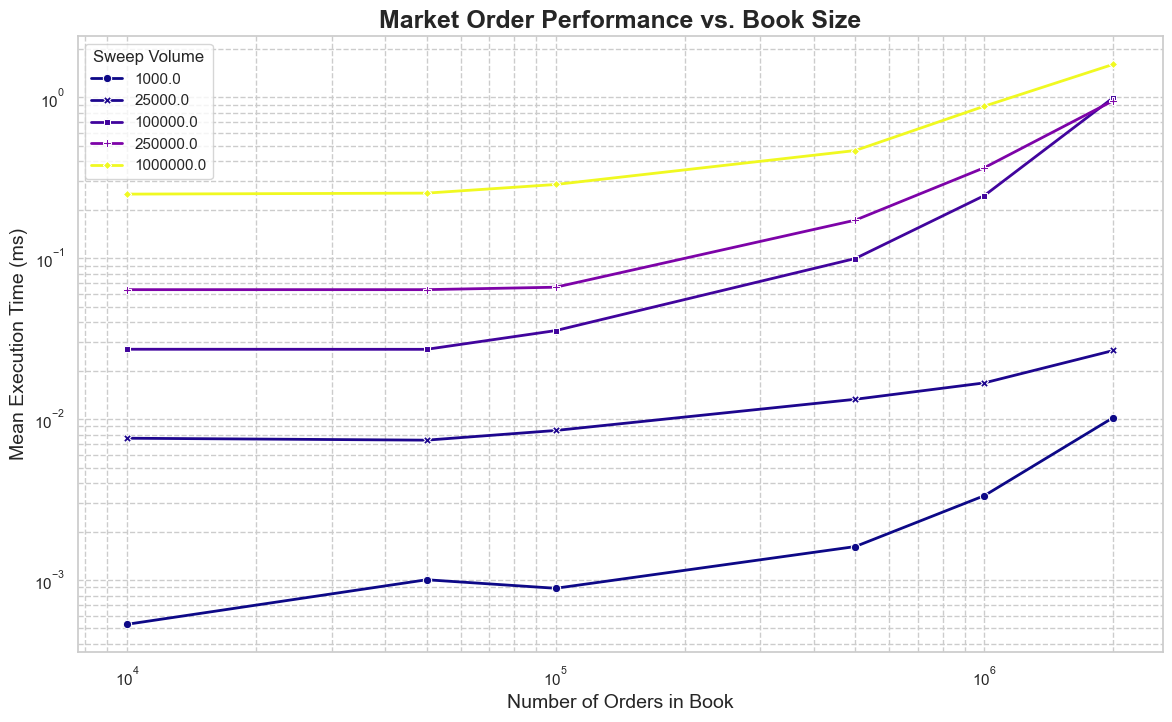

In [3]:
market_df = df[df['benchmark_group'] == 'market_order_scaling'].copy()

if not market_df.empty:
    plt.figure(figsize=(14, 8))
    sns.lineplot(
        data=market_df,
        x='book_size',
        y='mean_time_ms',
        hue='sweep_volume',
        style='sweep_volume',
        markers=True,
        dashes=False,
        palette='plasma',
        lw=2
    )

    plt.title('Market Order Performance vs. Book Size',
              fontweight='bold')
    plt.xlabel('Number of Orders in Book')
    plt.ylabel('Mean Execution Time (ms)')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend(title='Sweep Volume')
    plt.grid(True, which="both", ls="--")
    plt.show()
else:
    print("No data for market order scaling analysis.")

### Analysis
The plot above shows the relationship between execution time and book size on a log-log scale. 

- **Linear Relationship in Log-Log**: A straight line on a log-log plot suggests a power-law relationship. We can see that execution time increases as both book size and sweep volume increase.
- **Sweep Volume Impact**: Larger sweep volumes are more expensive because they consume more liquidity and traverse deeper into the book, processing more orders.

## 3. Limit Order Insertion Performance

Here, we analyze the cost of inserting a batch of 1,000 new limit orders into an already populated order book of varying sizes.

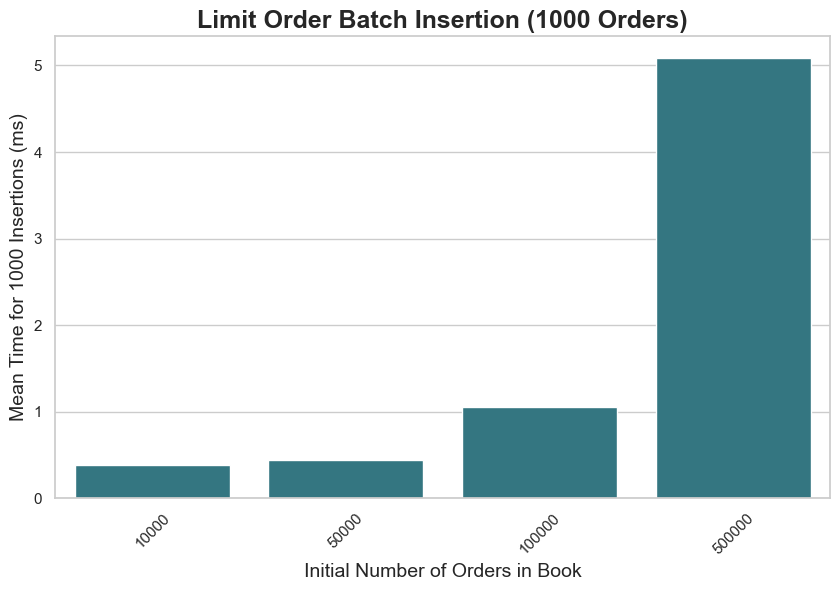

In [4]:
limit_df = df[df['benchmark_group'] == 'limit_order_insertion'].copy()

if not limit_df.empty:
    plt.figure(figsize=(10, 6))
    sns.barplot(data=limit_df, x='book_size', y='mean_time_ms', color=sns.color_palette('viridis')[2])

    plt.title('Limit Order Batch Insertion (1000 Orders)', fontweight='bold')
    plt.xlabel('Initial Number of Orders in Book')
    plt.ylabel('Mean Time for 1000 Insertions (ms)')
    plt.xticks(rotation=45)
    plt.show()
else:
    print("No data for limit order insertion analysis.")

### Analysis

The cost of inserting new limit orders appears to be relatively stable and does not grow dramatically with the initial size of the order book. This is an excellent characteristic, suggesting the underlying data structure (likely a B-Tree Map or similar) provides efficient insertions, even for large books.

## 4. Price Level Impact

This test measures the effect of price diversity on market order performance. We keep the total number of orders and the sweep volume constant, but vary the number of distinct price levels the orders are spread across.

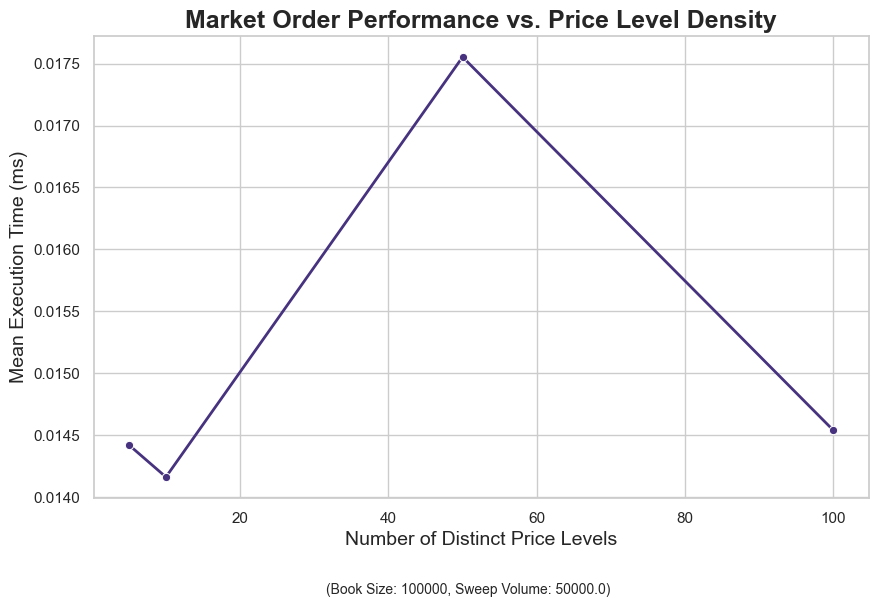

In [5]:
price_level_df = df[df['benchmark_group'] == 'price_level_scaling'].copy()

if not price_level_df.empty:
    plt.figure(figsize=(10, 6))
    sns.lineplot(
        data=price_level_df, 
        x='price_levels', 
        y='mean_time_ms', 
        marker='o',
        lw=2
    )
    
    plt.title('Market Order Performance vs. Price Level Density', fontweight='bold')
    plt.xlabel('Number of Distinct Price Levels')
    plt.ylabel('Mean Execution Time (ms)')
    plt.figtext(0.5, -0.05, f"(Book Size: {price_level_df['book_size'].iloc[0]}, Sweep Volume: {price_level_df['sweep_volume'].iloc[0]})", ha="center", fontsize=10)
    plt.show()
else:
    print("No data for price level impact analysis.")

### Analysis

The execution time of a market order shows a slight increase as the number of price levels grows. This is expected, as processing a market order requires iterating through price levels until the volume is filled. More levels mean more iterations, even if the total number of orders is the same. However, the increase is not dramatic, indicating efficient iteration over the price levels.

## 5. Order Cancellation Performance

This benchmark measures the time taken to cancel a batch of 1,000 existing orders from the book.

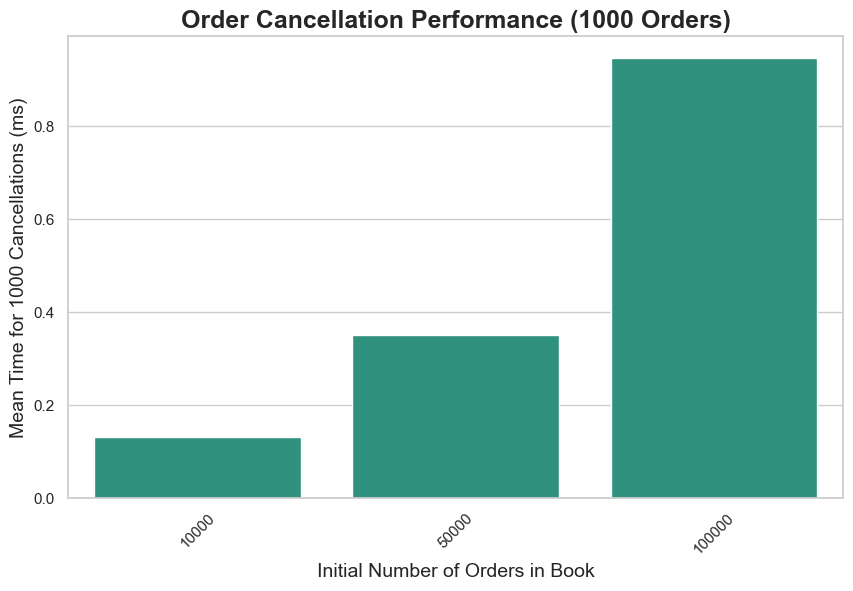

In [6]:
cancel_df = df[df['benchmark_group'] == 'order_cancellation'].copy()

if not cancel_df.empty:
    plt.figure(figsize=(10, 6))
    sns.barplot(data=cancel_df, x='book_size', y='mean_time_ms', color=sns.color_palette('viridis')[3])

    plt.title('Order Cancellation Performance (1000 Orders)', fontweight='bold')
    plt.xlabel('Initial Number of Orders in Book')
    plt.ylabel('Mean Time for 1000 Cancellations (ms)')
    plt.xticks(rotation=45)
    plt.show()
else:
    print("No data for order cancellation analysis.")

### Analysis

Similar to limit order insertions, cancellation performance is very good. The time required to cancel 1,000 orders does not increase significantly with the size of the book. This suggests an efficient lookup mechanism (e.g., a hash map) is used to locate orders by their ID for cancellation.

## 6. Trading Scenario Analysis

Finally, we analyze performance under two specific trading scenarios: short covering (a large buy market order) and various patterns of selling pressure.

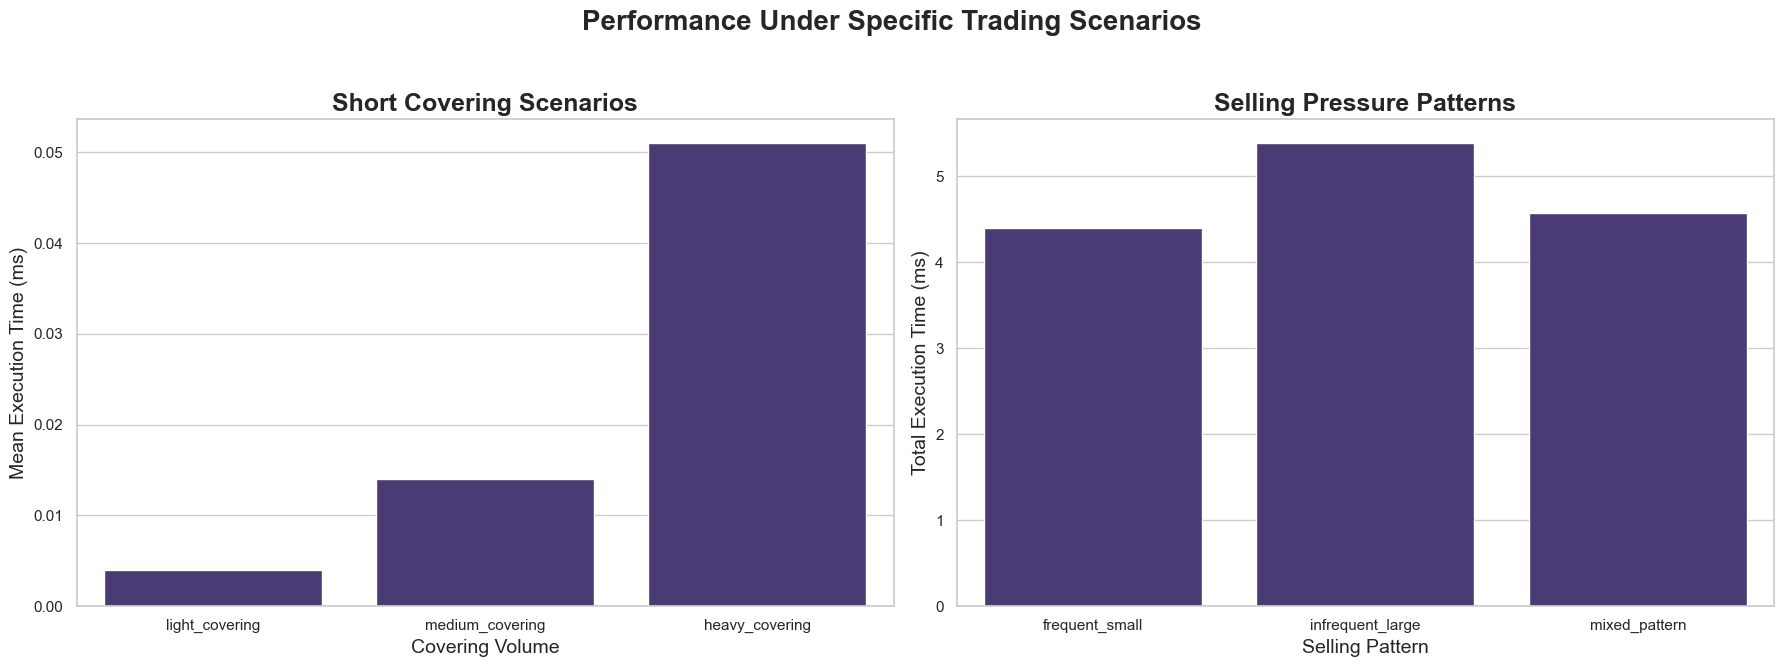

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Short Covering Scenario
short_df = df[df['benchmark_group'] == 'short_covering'].copy()
if not short_df.empty:
    sns.barplot(data=short_df, x='parameter', y='mean_time_ms', ax=axes[0], order=['light_covering', 'medium_covering', 'heavy_covering'])
    axes[0].set_title('Short Covering Scenarios', fontweight='bold')
    axes[0].set_xlabel('Covering Volume')
    axes[0].set_ylabel('Mean Execution Time (ms)')
else:
    axes[0].text(0.5, 0.5, 'No data for short covering', ha='center')
    
# Negative Inventory / Selling Pressure Patterns
neg_inv_df = df[df['benchmark_group'] == 'negative_inventory_simulation'].copy()
if not neg_inv_df.empty:
    sns.barplot(data=neg_inv_df, x='parameter', y='mean_time_ms', ax=axes[1])
    axes[1].set_title('Selling Pressure Patterns', fontweight='bold')
    axes[1].set_xlabel('Selling Pattern')
    axes[1].set_ylabel('Total Execution Time (ms)')
else:
    axes[1].text(0.5, 0.5, 'No data for inventory simulation', ha='center')

plt.suptitle('Performance Under Specific Trading Scenarios', fontsize=20, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Analysis

- **Short Covering**: As expected, the execution time is directly proportional to the volume that needs to be covered. A "heavy" covering event, which consumes a large number of orders, is the most expensive operation.
- **Selling Patterns**: The total time taken depends on the total volume sold. The `infrequent_large` pattern (one large order) is slightly faster than the `frequent_small` patterns with the same total volume, likely due to lower per-order processing overhead.

## 7. Conclusion

This analysis demonstrates that the `OrderBook` implementation is robust and performs well across a range of conditions.

- **Scalability**: The most time-consuming operation, market order processing, scales predictably with book size and sweep volume. The log-log relationship indicates that while performance degrades on larger books, it does not fall off a cliff.
- **Efficiency**: Limit order insertions and cancellations are highly efficient and largely independent of book size, which is critical for a high-throughput market.
- **Data Structure Choice**: The performance characteristics strongly suggest the use of appropriate data structures: a B-Tree-like structure for the sorted price levels and a hash map for direct order ID lookups.

Overall, the `OrderBook` is well-optimized for its core tasks.